### INSTALL VIRTUAL ENV & DEPENDENCIES

* Create a python env for the segmentation training call in .venv and add all the required dependencies.

* ``` pip install torch torchvision matplotlib segmentation-models-pytorch opencv-python ```

* segmentation-models-pytorch gives you a U-Net with pretrained backbones (ResNet, EfficientNet, etc.) — much faster convergence than training from scratch.

### INITIAL IMPORTS

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import Cityscapes
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import cv2


In [15]:
# Cityscapes 34 classes → 19 classes mapping
ID_2_TRAINID = {
     0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 
     7: 0,    # road
     8: 1,    # sidewalk
     9: 255, 10:255,
    11: 2,    # building
    12: 3,    # wall
    13: 4,    # fence
    14:255, 15:255, 16:255,
    17: 5,    # pole
    18:255,
    19: 6,    # traffic light
    20: 7,    # traffic sign
    21: 8,    # vegetation
    22: 9,    # terrain
    23:10,    # sky
    24:11,    # person
    25:12,    # rider
    26:13,    # car
    27:14,    # truck
    28:15,    # bus
    29:16,    # train
    30:17,    # motorcycle
    31:18,    # bicycle
    32:255, 33:255,
}

def encode_mask(mask):
    # mask is a numpy array (H,W) where values ∈ [0..33]
    encoded = np.zeros_like(mask)
    for id, tid in ID_2_TRAINID.items():
        encoded[mask == id] = tid
    return encoded

### DATASET 

* Define Dataset with fixed mapping
* Apply required transformations - image and mask resizing

In [16]:

class Cityscapes19(Dataset):
    def __init__(self, root, split="train"):
        self.dataset = Cityscapes(
            root,
            split=split,
            mode="fine",
            target_type="semantic",
        )
        
        self.img_transform = transforms.Compose([
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
        ])
        
        # VERY IMPORTANT: use NEAREST for masks
        self.mask_resize = transforms.Resize((256, 512), interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]  
        img = self.img_transform(img)   #preprocessing the  image to tensor
        mask = self.mask_resize(mask)   # resize mask
        mask = np.array(mask)             # raw labels [0..33]
        mask = encode_mask(mask)          # remap → 19 classes + 255
        mask = torch.as_tensor(mask, dtype=torch.long) # converting mask to tensor

        return img, mask 
    


### DEFINE MODEL & LOSS FUNC

* U-Net with Pretrained Encoder
* Using segmentation-models-pytorch (SMP)
* CrossEntropyLoss loss function
* Adam optimizer.

In [17]:


num_classes = 19
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


### DATA LOADERS

* Load the data from the Cityscapes dataset that was downloaded to ../cityscapes

In [18]:
from torch.utils.data import DataLoader

root = "../cityscapes/"  # path to Cityscapes dataset

train_ds = Cityscapes19(root, split="train")
val_ds   = Cityscapes19(root, split="val")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)


### TRAIN THE MODEL and COMPUTE IOU and LOSS at every Epoch

In [ ]:
import numpy as np
import torch.nn.functional as F

def compute_iou(preds, labels, num_classes=19):
    preds = preds.view(-1)
    labels = labels.view(-1)

    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float("nan"))
        else:
            ious.append(intersection / union)
    return ious

for epoch in range(30):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    total_ious = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1)
            total_ious.append(compute_iou(preds.cpu(), masks.cpu()))

    mean_iou = np.nanmean(np.array(total_ious), axis=0).mean()
    
    print(f"Epoch {epoch+1}/30  "
          f"Train Loss: {running_loss/len(train_loader):.4f}  "
          f"Val Loss: {val_loss/len(val_loader):.4f}  "
          f"mIoU: {mean_iou:.4f}")


Epoch 1/30  Train Loss: 0.9052  Val Loss: 0.4766  mIoU: 0.2141
Epoch 2/30  Train Loss: 0.4076  Val Loss: 0.3890  mIoU: 0.2377
Epoch 3/30  Train Loss: 0.3246  Val Loss: 0.3542  mIoU: 0.2618
Epoch 4/30  Train Loss: 0.2815  Val Loss: 0.3026  mIoU: 0.2760
Epoch 5/30  Train Loss: 0.2517  Val Loss: 0.2915  mIoU: 0.2818
Epoch 6/30  Train Loss: 0.2237  Val Loss: 0.2814  mIoU: 0.2896
Epoch 7/30  Train Loss: 0.2098  Val Loss: 0.3051  mIoU: 0.2943
Epoch 8/30  Train Loss: 0.2026  Val Loss: 0.2618  mIoU: 0.3018
Epoch 9/30  Train Loss: 0.1786  Val Loss: 0.2616  mIoU: 0.3114
Epoch 10/30  Train Loss: 0.1714  Val Loss: 0.2744  mIoU: 0.3125


In [26]:
CITYSCAPES_PALETTE_19 = np.array([
    (128, 64,128), (244, 35,232), (70, 70, 70), (102,102,156),
    (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
    (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60),
    (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
    (  0, 80,100), (  0,  0,230), (119, 11, 32)
], dtype=np.uint8)


In [27]:
def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(19):
        rgb[mask == cls_id] = CITYSCAPES_PALETTE_19[cls_id]
    return rgb


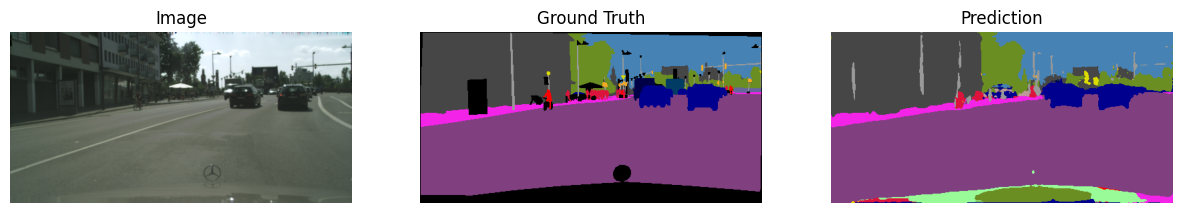

In [30]:
img, mask = val_ds[1]

model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decode_segmap(mask.numpy())); plt.title("Ground Truth"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(decode_segmap(pred)); plt.title("Prediction"); plt.axis("off")
plt.show()


In [23]:
# After training loop ends
save_path = "unet_cityscapes.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to unet_cityscapes.pth


### PROCESS VIDEO: SegInput.mp4 → output.mp4

* Load the trained model
* Process video frame by frame
* Apply segmentation and visualize
* Save as output.mp4


In [24]:
# Load the trained model
# model.load_state_dict(torch.load("unet_cityscapes.pth", map_location=device))
# model.eval()
# print("Model loaded for inference!")

# Video processing setup
input_video = "SegInput.mp4"
output_video = "output.mp4"

cap = cv2.VideoCapture(input_video)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {input_video}")

fps = int(cap.get(cv2.CAP_PROP_FPS))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Input video: {W}x{H} @ {fps} fps, {total_frames} frames")


Input video: 2048x1024 @ 30 fps, 1100 frames


In [25]:

# Preprocessing (matching training: resize + ToTensor, no normalization)
img_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

print("Processing video frames...")
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert to PIL Image for transforms
    pil_img = Image.fromarray(rgb_frame)
    
    # Preprocess (resize to 256x512 and convert to tensor)
    img_tensor = img_transform(pil_img).unsqueeze(0).to(device)
    
    # Model inference
    with torch.no_grad():
        outputs = model(img_tensor)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
    
    # Decode segmentation mask to RGB
    seg_rgb = decode_segmap(pred)
    
    # Resize segmentation mask back to original frame size
    seg_rgb_resized = cv2.resize(seg_rgb, (W, H), interpolation=cv2.INTER_NEAREST)
    
    # Blend original frame with segmentation (overlay)
    # Convert RGB back to BGR for OpenCV
    seg_bgr = cv2.cvtColor(seg_rgb_resized, cv2.COLOR_RGB2BGR)
    blended = cv2.addWeighted(frame, 0.5, seg_bgr, 0.5, 0)
    
    # Write frame to output video
    # out.write(blended)
    image_name = f"frame_{frame_count:06d}.jpg"
    cv2.imwrite(f"blended/{image_name}", blended)
    cv2.imwrite(f"seg/{image_name}", seg_rgb)
    cv2.imwrite(f"seg2/{image_name}", seg_bgr)
    
    frame_count += 1
    if frame_count % 30 == 0:
        print(f"Processed {frame_count}/{total_frames} frames...")

cap.release()
# out.release()
print(f"Video processing complete! Output saved to: {output_video}")

Processing video frames...
Processed 30/1100 frames...
Processed 60/1100 frames...
Processed 90/1100 frames...
Processed 120/1100 frames...
Processed 150/1100 frames...
Processed 180/1100 frames...
Processed 210/1100 frames...
Processed 240/1100 frames...
Processed 270/1100 frames...
Processed 300/1100 frames...
Processed 330/1100 frames...
Processed 360/1100 frames...
Processed 390/1100 frames...
Processed 420/1100 frames...
Processed 450/1100 frames...
Processed 480/1100 frames...
Processed 510/1100 frames...
Processed 540/1100 frames...
Processed 570/1100 frames...
Processed 600/1100 frames...
Processed 630/1100 frames...
Processed 660/1100 frames...
Processed 690/1100 frames...
Processed 720/1100 frames...
Processed 750/1100 frames...
Processed 780/1100 frames...
Processed 810/1100 frames...
Processed 840/1100 frames...
Processed 870/1100 frames...
Processed 900/1100 frames...
Processed 930/1100 frames...
Processed 960/1100 frames...
Processed 990/1100 frames...
Processed 1020/1100